#Pre req

##Install Pre req from Kaggle

In [1]:
!pip install kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
cd /root/.kaggle

/root/.kaggle


In [4]:
!pwd
!ls

/root/.kaggle


In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mikail1010","key":"ae14ca709014e4cafee80fa0005caa72"}'}

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
cd /content

/content


In [8]:
!kaggle datasets list

ref                                                       title                                                size  lastUpdated          downloadCount  
--------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-wallstreetsbets-posts                       Reddit WallStreetBets Posts                           6MB  2021-02-09 07:27:13            512  
michau96/restaurant-business-rankings-2020                Restaurant Business Rankings 2020                    16KB  2021-01-30 14:20:45            441  
aagghh/crypto-telegram-groups                             Crypto telegram groups                              297MB  2021-02-02 09:58:25             91  
yorkehead/stock-market-subreddits                         Stock Market Subreddits                               1MB  2021-01-29 13:53:50            101  
timoboz/superbowl-history-1967-2020                       Superbowl History 

In [9]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 8.28MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 29.7MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 27.4MB/s]


##Import necessary libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chardet
from wordcloud import WordCloud
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import xgboost as xgb
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler

from collections import Counter

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

from sklearn.ensemble import RandomForestClassifier

#Setting for notebook
%matplotlib inline
pd.options.display.max_columns = None
pd.options.display.max_rows = None

#Loading the data

In [33]:
with open("test.csv", 'rb') as file:
    print(chardet.detect(file.read()))

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}


In [34]:
Tweets = pd.read_csv("/content/train.csv", encoding="utf-8")

#Preprocessing

##Exploring the data

In [35]:
Tweets.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [36]:
Tweets.describe(include="all")

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [37]:
Tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


###Exploring the keyword and location cols

In [38]:
Keyworddict_unique = Tweets["keyword"].unique()
print(len(Keyworddict_unique))
print(Keyworddict_unique)

222
[nan 'ablaze' 'accident' 'aftershock' 'airplane%20accident' 'ambulance'
 'annihilated' 'annihilation' 'apocalypse' 'armageddon' 'army' 'arson'
 'arsonist' 'attack' 'attacked' 'avalanche' 'battle' 'bioterror'
 'bioterrorism' 'blaze' 'blazing' 'bleeding' 'blew%20up' 'blight'
 'blizzard' 'blood' 'bloody' 'blown%20up' 'body%20bag' 'body%20bagging'
 'body%20bags' 'bomb' 'bombed' 'bombing' 'bridge%20collapse'
 'buildings%20burning' 'buildings%20on%20fire' 'burned' 'burning'
 'burning%20buildings' 'bush%20fires' 'casualties' 'casualty'
 'catastrophe' 'catastrophic' 'chemical%20emergency' 'cliff%20fall'
 'collapse' 'collapsed' 'collide' 'collided' 'collision' 'crash' 'crashed'
 'crush' 'crushed' 'curfew' 'cyclone' 'damage' 'danger' 'dead' 'death'
 'deaths' 'debris' 'deluge' 'deluged' 'demolish' 'demolished' 'demolition'
 'derail' 'derailed' 'derailment' 'desolate' 'desolation' 'destroy'
 'destroyed' 'destruction' 'detonate' 'detonation' 'devastated'
 'devastation' 'disaster' 'displaced' 'd

In [39]:
Keyword_col = Tweets["keyword"].dropna(axis=0)
Keyword_col_split = Keyword_col.str.split(expand=True, pat="%20")
Keyword_col_split.head(100)

,0,1,2
31,ablaze,None,None
32,ablaze,None,None
33,ablaze,None,None
34,ablaze,None,None
35,ablaze,None,None
36,ablaze,None,None
37,ablaze,None,None
38,ablaze,None,None
39,ablaze,None,None
40,ablaze,None,None


In [40]:
Keyword_col_split[0].unique()

array(['ablaze', 'accident', 'aftershock', 'airplane', 'ambulance',
       'annihilated', 'annihilation', 'apocalypse', 'armageddon', 'army',
       'arson', 'arsonist', 'attack', 'attacked', 'avalanche', 'battle',
       'bioterror', 'bioterrorism', 'blaze', 'blazing', 'bleeding',
       'blew', 'blight', 'blizzard', 'blood', 'bloody', 'blown', 'body',
       'bomb', 'bombed', 'bombing', 'bridge', 'buildings', 'burned',
       'burning', 'bush', 'casualties', 'casualty', 'catastrophe',
       'catastrophic', 'chemical', 'cliff', 'collapse', 'collapsed',
       'collide', 'collided', 'collision', 'crash', 'crashed', 'crush',
       'crushed', 'curfew', 'cyclone', 'damage', 'danger', 'dead',
       'death', 'deaths', 'debris', 'deluge', 'deluged', 'demolish',
       'demolished', 'demolition', 'derail', 'derailed', 'derailment',
       'desolate', 'desolation', 'destroy', 'destroyed', 'destruction',
       'detonate', 'detonation', 'devastated', 'devastation', 'disaster',
       'displa

In [41]:
Keyword = Keyword_col_split[0] + " " +  Keyword_col_split[1] + " " +   Keyword_col_split[2]
Test = Keyword.dropna(axis=0)
Keyword.head(100)

31     NaN
32     NaN
33     NaN
34     NaN
35     NaN
36     NaN
37     NaN
38     NaN
39     NaN
40     NaN
41     NaN
42     NaN
43     NaN
44     NaN
45     NaN
46     NaN
47     NaN
48     NaN
49     NaN
50     NaN
51     NaN
52     NaN
53     NaN
54     NaN
55     NaN
56     NaN
57     NaN
58     NaN
59     NaN
60     NaN
61     NaN
62     NaN
63     NaN
64     NaN
65     NaN
66     NaN
67     NaN
68     NaN
69     NaN
70     NaN
71     NaN
72     NaN
73     NaN
74     NaN
75     NaN
76     NaN
77     NaN
78     NaN
79     NaN
80     NaN
81     NaN
82     NaN
83     NaN
84     NaN
85     NaN
86     NaN
87     NaN
88     NaN
89     NaN
90     NaN
91     NaN
92     NaN
93     NaN
94     NaN
95     NaN
96     NaN
97     NaN
98     NaN
99     NaN
100    NaN
101    NaN
102    NaN
103    NaN
104    NaN
105    NaN
106    NaN
107    NaN
108    NaN
109    NaN
110    NaN
111    NaN
112    NaN
113    NaN
114    NaN
115    NaN
116    NaN
117    NaN
118    NaN
119    NaN
120    NaN
121    NaN

In [42]:
Keyword_col = Tweets["keyword"]
Keyword_col1 = pd.Series(Keyword_col).str.replace('%20', ' ', regex=True)
Keyword_col1.unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown up', 'body bag', 'body bagging', 'body bags',
       'bomb', 'bombed', 'bombing', 'bridge collapse',
       'buildings burning', 'buildings on fire', 'burned', 'burning',
       'burning buildings', 'bush fires', 'casualties', 'casualty',
       'catastrophe', 'catastrophic', 'chemical emergency', 'cliff fall',
       'collapse', 'collapsed', 'collide', 'collided', 'collision',
       'crash', 'crashed', 'crush', 'crushed', 'curfew', 'cyclone',
       'damage', 'danger', 'dead', 'death', 'deaths', 'debris', 'deluge',
       'deluged', 'demolish', 'demolished', 'demolition', 'derail',
       'derailed', 'derailment', 'desol

##Test train split

In [43]:
Tweets, Tweets_valid = train_test_split(Tweets, test_size=0.2, random_state=42, shuffle=True)
print(type(Tweets), type(Tweets_valid))
print(Tweets.shape, Tweets_valid.shape)

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
(6090, 5) (1523, 5)


In [44]:
Tweets_valid.head(10)

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0
5559,7934,rainstorm,NaN,@Calum5SOS you look like you got caught in a r...,0
1765,2538,collision,NaN,my favorite lady came to our volunteer meeting...,1
1817,2611,crashed,NaN,@brianroemmele UX fail of EMV - people want to...,1
6810,9756,tragedy,"Los Angeles, CA",Can't find my ariana grande shirt this is a f...,0
4398,6254,hijacking,"Athens,Greece",The Murderous Story Of AmericaÛªs First Hijac...,1


In [45]:
Tweets.reset_index(drop=True, inplace=True)
Tweets_valid.reset_index(drop=True, inplace=True)

##Dropping Nul cols

In [46]:
Tweets.isnull().sum()

id             0
keyword       48
location    2020
text           0
target         0
dtype: int64

In [47]:
Tweets.drop(labels=["keyword", "location"], axis=1, inplace=True)
Tweets.head()

,id,text,target
0,7128,Courageous and honest analysis of need to use ...,1
1,4688,@ZachZaidman @670TheScore wld b a shame if tha...,0
2,6984,Tell @BarackObama to rescind medals of 'honor'...,1
3,4103,Worried about how the CA drought might affect ...,1
4,6706,@YoungHeroesID Lava Blast &amp; Power Red #Pan...,0


## Analyzing the data

In [48]:
DisaterTweetCount = len(Tweets[Tweets["target"] == 1])
DisaterTweetPercentage = (DisaterTweetCount / Tweets.shape[0]) * 100
NormalTweetPercentage = 100 - DisaterTweetPercentage
print("Percentage of disaster tweets: ", DisaterTweetPercentage)
print("Percentage of normal tweets: ", NormalTweetPercentage)

Percentage of disaster tweets:  43.05418719211823
Percentage of normal tweets:  56.94581280788177


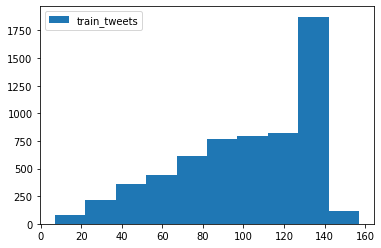

In [49]:
length_train = Tweets['text'].str.len() 
plt.hist(length_train, label="train_tweets") 
plt.legend() 
plt.show()

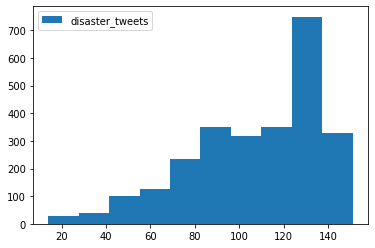

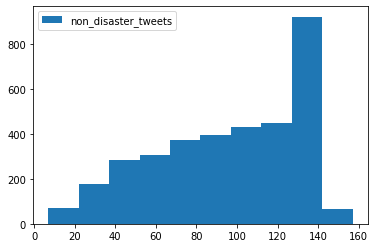

In [50]:
length_disaster_tweets = Tweets[Tweets["target"] == 1]['text'].str.len() 
plt.hist(length_disaster_tweets, label="disaster_tweets")

plt.legend() 
plt.show()

length_non_disaster_tweets = Tweets[Tweets["target"] != 1]['text'].str.len() 
plt.hist(length_non_disaster_tweets, label="non_disaster_tweets")
plt.legend() 
plt.show()

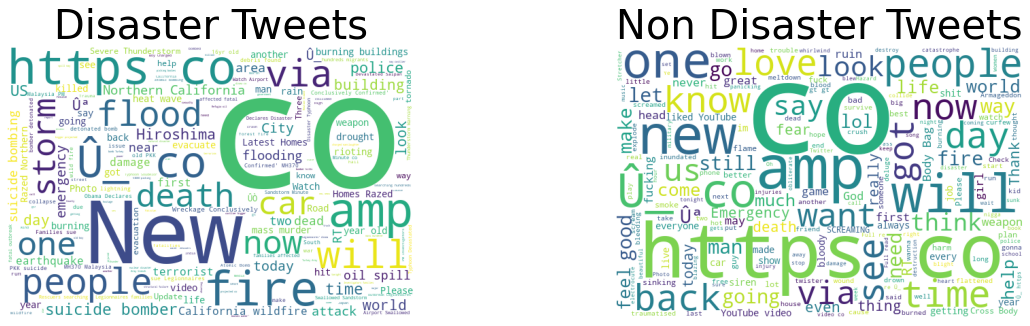

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 5])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(Tweets[Tweets["target"] == 1]['text']))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(Tweets[Tweets["target"] != 1]['text']))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);

##Cleaning the data

In [52]:
def RemoveUncleanText(text):
  text = text.lower()
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
  return text

Tweets['text'] = Tweets['text'].apply(lambda x: RemoveUncleanText(x))
Tweets.head()

,id,text,target
0,7128,courageous and honest analysis of need to use ...,1
1,4688,zachzaidman wld b a shame if that golf cart b...,0
2,6984,tell barackobama to rescind medals of honor gi...,1
3,4103,worried about how the ca drought might affect ...,1
4,6706,youngheroesid lava blast amp power red panther...,0


In [53]:
tokenizer=nltk.tokenize.RegexpTokenizer(r'\w+')
Tweets['text'] = Tweets['text'].apply(lambda x:tokenizer.tokenize(x))
Tweets.head()

,id,text,target
0,7128,"[courageous, and, honest, analysis, of, need, ...",1
1,4688,"[zachzaidman, wld, b, a, shame, if, that, golf...",0
2,6984,"[tell, barackobama, to, rescind, medals, of, h...",1
3,4103,"[worried, about, how, the, ca, drought, might,...",1
4,6706,"[youngheroesid, lava, blast, amp, power, red, ...",0


In [54]:
nltk.download('stopwords')
stopwords.words('english')
len(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


179

In [55]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words 
Tweets['text'] = Tweets['text'].apply(lambda x : remove_stopwords(x))
Tweets.head()

,id,text,target
0,7128,"[courageous, honest, analysis, need, use, atom...",1
1,4688,"[zachzaidman, wld, b, shame, golf, cart, becam...",0
2,6984,"[tell, barackobama, rescind, medals, honor, gi...",1
3,4103,"[worried, ca, drought, might, affect, extreme,...",1
4,6706,"[youngheroesid, lava, blast, amp, power, red, ...",0


In [56]:
def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

# Tweets['text'] = Tweets['text'].apply(lambda x : combine_text(x))
# Tweets.head()

In [57]:
Tweets_test.drop(labels=["keyword", "location"], axis=1, inplace=True)
Tweets_test['text'] = Tweets_test['text'].apply(lambda x: RemoveUncleanText(x))
Tweets_test['text'] = Tweets_test['text'].apply(lambda x:tokenizer.tokenize(x))
Tweets_test['text'] = Tweets_test['text'].apply(lambda x : remove_stopwords(x))

#Training the model

In [58]:
word_corpus = {}
for i in Tweets['text']:
  for j in i:
  
    if j in word_corpus:
      word_corpus[j] += 1
    else:
      word_corpus[j] = 1
print(len(word_corpus))
word_corpus_df = pd.DataFrame(word_corpus.items(), columns=['Word', 'Freq'])

word_corpus_df.sort_values('Freq', axis=0, inplace=True, ascending=False, ignore_index=True)
word_corpus_df.head(10)

14282


,Word,Freq
0,û,341
1,like,273
2,amp,238
3,im,235
4,fire,194
5,get,184
6,via,176
7,new,172
8,people,167
9,news,156


##Embeddings

In [59]:
Tweets_Com = pd.DataFrame(Tweets['text'].apply(lambda x : combine_text(x)))
Tweets_valid_Com = pd.DataFrame(Tweets_valid['text'].apply(lambda x : combine_text(x)))
Tweets_Com.head()

,text
0,courageous honest analysis need use atomic bom...
1,zachzaidman wld b shame golf cart became engul...
2,tell barackobama rescind medals honor given us...
3,worried ca drought might affect extreme weathe...
4,youngheroesid lava blast amp power red panther...


In [60]:
embedded_tweets = [one_hot(word, len(word_corpus_df)) for word in Tweets_Com['text']]
embedded_tweets_valid = [one_hot(word, len(word_corpus_df)) for word in Tweets_valid_Com['text']]
print(embedded_tweets)

[[2625, 14251, 84, 13306, 9447, 13826, 6349, 3734, 4201, 4189, 12873], [7041, 967, 595, 5313, 8024, 2707, 953, 3610, 9481, 11021], [2002, 3915, 12749, 11161, 13347, 10509, 13054, 2061, 1145, 6967, 5501, 4290, 6297, 5289], [1747, 6453, 4859, 7730, 4021, 13627, 3337, 663, 10868], [1342, 4529, 2779, 6297, 8328, 992, 1071, 5056, 1752], [8255, 12161, 10701, 9475, 7809, 3098, 11056], [7806, 1256, 7855, 7873, 1812, 811, 6028, 10261, 1588], [9474, 13925, 2951, 10676, 7106, 12119, 9489, 6496, 7809, 10037], [947, 1070, 13793, 7625, 3894, 1560], [7981, 14230, 7450, 422, 1279, 4251, 3166, 4162, 13645, 9616], [7892, 11641, 13722, 9998, 5551, 2460], [8805, 1577, 150, 7809, 7809, 12700, 12662, 12715, 12517, 744, 13114], [2037, 9877, 6137, 7502, 2361, 3344], [6610, 5308, 13509, 7632, 8427, 2111, 6056, 6426, 2401, 9374, 10740, 1392], [892, 6474, 8665, 4990, 1720, 11240, 13802, 879, 1043, 5317], [4162, 9016, 13806, 4815, 12829, 13054, 8795, 10753, 1846], [11999, 8107, 12142, 9180, 10984, 4705, 5008, 651

In [61]:
max_len = 0
for i in embedded_tweets:
  if len(i) > max_len:
    max_len = len(i)

max_len = max_len + 10
print(max_len)

33


In [62]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(Tweets_Com['text'], key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))
print(length_long_sentence)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
23


In [63]:
padded_tweets = np.array(pad_sequences(embedded_tweets, max_len, padding='post'))
padded_tweets_valid = np.array(pad_sequences(embedded_tweets_valid, max_len, padding='post'))

print(padded_tweets)

[[ 2625 14251    84 ...     0     0     0]
 [ 7041   967   595 ...     0     0     0]
 [ 2002  3915 12749 ...     0     0     0]
 ...
 [ 2388  5569 12950 ...     0     0     0]
 [  892  6474  8665 ...     0     0     0]
 [ 3981 13329 13343 ...     0     0     0]]


In [64]:
X_train, X_test, y_train, y_test = padded_tweets, padded_tweets_valid, Tweets['target'], Tweets_valid['target']

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(6090, 33) (1523, 33) (6090,) (1523,)


In [ ]:
model = Sequential()
model.add(Embedding(len(word_corpus_df), 20, input_length=max_len))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.fit(X_train, y_train, epochs=100, verbose=1)

In [66]:
y_pred_train = model.predict(X_train).round()
y_pred_test = model.predict(X_test).round()

# print(y_pred_train)
# print(y_train)

print(precision_score(y_train, y_pred_train, average='micro'), recall_score(y_train, y_pred_train, average='micro'))
print(precision_score(y_test, y_pred_test, average='micro'), recall_score(y_test, y_pred_test, average='micro'))

0.9883415435139573 0.9883415435139573
0.562048588312541 0.562048588312541


#Submitting the files

In [70]:
Tweets_test = pd.read_csv("test.csv", low_memory=False)

In [71]:
Tweets_test.drop(labels=["keyword", "location"], axis=1, inplace=True)
Tweets_test['text'] = Tweets_test['text'].apply(lambda x: RemoveUncleanText(x))
Tweets_test['text'] = Tweets_test['text'].apply(lambda x:tokenizer.tokenize(x))
Tweets_test['text'] = Tweets_test['text'].apply(lambda x : remove_stopwords(x))
Tweets_Com_test = pd.DataFrame(Tweets_test['text'].apply(lambda x : combine_text(x)))

In [72]:
embedded_tweets_test = [one_hot(word, len(word_corpus_df)) for word in Tweets_Com_test['text']]
padded_tweets_test = np.array(pad_sequences(embedded_tweets_test, max_len, padding='post'))

X_test = padded_tweets_test


In [75]:
column_one = Tweets_final_test["id"]
column_two = model.predict(X_test).round().flatten()

thedict = {"id":column_one , 'target': column_two }

y_pred = pd.DataFrame(thedict)
y_pred.to_csv('test_pred.csv', index=False)

In [76]:
from google.colab import files
files.download('test_pred.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>